# CogPonder: A Model-Agnostic Approach to Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of response. Yet, most advanced techniques in machine learning cannot capture such a duality of decision making.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate CogPonder architecture, a model-agnostic architecture that optimizes for the speed-accuracy of human-like responses.

The architecture iterates over a recurrent model but only terminates and produce output once it reaches a halting point in time.


Unlike sequential sampling and accumulative models, all the parameters of this model *seem* cognitively interpretable.

## Problem Setting

### N-back Task

The subject is presented with a sequence of stimuli, and the task consists of indicating when the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock N-back dataset to evaluate the architecture. For each subject, the mock N-back dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$.


### Decision Model
We want to learn a supervised model of the function $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each step is considered 100ms. - Halting probability ($\lambda_n$).


In case of the N-back task, X is a series of recent N stimuli symbols, e.g., A, B, C, D, ..., $y$ is either TARGET or NON_TARGET.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch.


### Criterion

$L = L_{cross\_entropy} + L_{target} + L_{non\_target}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from cogponder import NBackDataset, PonderNet, ICOM, evaluate

## Data

In [2]:


# generate mock n-back data

n_stimuli = 6

dataset = NBackDataset(n_subjects=2, n_trials=100, n_stimuli=6)

X, targets, responses, response_times = dataset[0]
dataset = TensorDataset(X, targets.float(), responses, response_times)

In [3]:
# evaluate the model

MAX_STEPS = 100 # response_times.max() + 10
N_OUTPUTS = torch.unique(targets).size()[0]

model = PonderNet(ICOM, n_stimuli+1, n_stimuli, N_OUTPUTS, MAX_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = evaluate(model, dataset, optimizer, n_epochs=1000, batch_size=4, max_steps=MAX_STEPS)

model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results

Epochs: 100%|██████████| 1000/1000 [02:28<00:00,  6.75it/s]


In [4]:
model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results

model(X_test)[2], rt_test

(tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
         99, 99]),
 tensor([26,  3,  2, 13,  2,  1, 21,  3,  3,  4,  4,  8,  3, 20,  1,  9,  2, 12,
          4, 10], dtype=torch.int32))

/usr/local/Caskroom/miniforge/base/envs/ponder/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


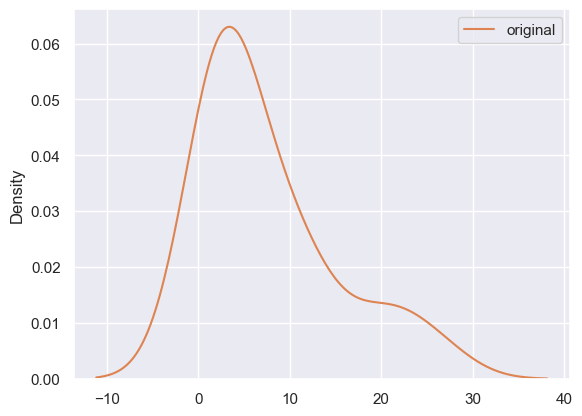

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(model(X_test)[2], label='predicted')
sns.kdeplot(rt_test, label='original')

plt.legend()
plt.show()